# B&O Model Checking For The Medium-Variance-Shift Case

Bastos & O'Hagan provided a great set of diagnostic tools for testing whether or not a Gaussian process (GP) is a reasonable emulator for an expensive simulator. Our use case is slightly different than theirs. We don't necessarily care about our GPs matching some underlying simulator. Rather, given a set of curves from a hierarchy of simulators, we wish to be able to discern whether all curves are drawn from the same simulator. 

This notebook implements B&O diagnostics for the case where we are trying to fit curves from three different GPs, all of which have the same length scale, but have different variances: of 1, 3, and 0.33 respectively. (Other shift factors can be implemented easily, but results shown and commented on are for factor 3 case.) The goal of the notebook is to find out how the B&O diagnostics show that the three curves are not, in fact, drawn from the same GP.

First we do some initialization

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import xarray as xa
import scipy.stats as stats
from scipy.special import loggamma
from statsmodels.sandbox.distributions.mv_normal import MVT
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import wraps
from cycler import cycler
from itertools import cycle
# from fastcache import lru_cache
import inspect
import gsum
from gsum import rbf, default_attributes, cholesky_errors, mahalanobis, lazy_property, pivoted_cholesky
from gsum import ConjugateGaussianProcess, ConjugateStudentProcess, Diagnostic, GraphicalDiagnostic

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

%load_ext Cython
%matplotlib inline

In [2]:
mpl.rcParams['figure.dpi'] = 120
# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True
n_ref = 1000   #parameter for our graphical diagnostic

Then we pick the points at which we will compute the cuvres, and generate a mask that divides these points into "training" and "testing" sets. 

In [3]:
X_full = np.atleast_2d(np.linspace(0, 20, 41)).T
mask = np.array([i % 3 == 0 for i in range(len(X_full))])
X = X_full[mask]
X_test = X_full[~mask]

We also define the length-scale mesh we will use later, for length-scale estimation

In [4]:
ls_mesh = np.linspace(0.1, 7, 100)

Now we define the three GPs we will use to generate data.

We also use a "nugget" in defining the GPs, in order to try and ameliorate singular-matrix-inversion issues. 

First we define the parameters of the GPs: the base variance, factor by which that is shifted up and down, and the base length scale, which in this example is not shifted. We also set the nugget's standard deviation. Note that the variance (which is what's often quoted for nuggets) is, of course, the square of that.

In [5]:
basevariance=1.0; varianceshiftfactor=3.0; baselengthscale=3.0; lengthscaleshift=0

nugget_sd = 1e-4

Now we can define our three kernels, and the corresponding three GPs: gp1, gp2, and gp3

In [6]:
shiftvarup_kernel=C(basevariance*varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
shiftvardown_kernel=C(basevariance/varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
true_kernel = C(basevariance, (1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthup_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale+lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthdown_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale-lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#kernel = true_kernel

gp1 = GaussianProcessRegressor(kernel=true_kernel, n_restarts_optimizer=9, optimizer=None,)
gp2 = GaussianProcessRegressor(kernel=shiftvarup_kernel,n_restarts_optimizer=9, optimizer=None)
gp3 = GaussianProcessRegressor(kernel=shiftvardown_kernel,n_restarts_optimizer=9, optimizer=None)

#kernel = true_kernel
#orders = np.arange(n_samples)
#ratio = 0.5  # Expansion parameter

## First example

Now we can generate our first data set

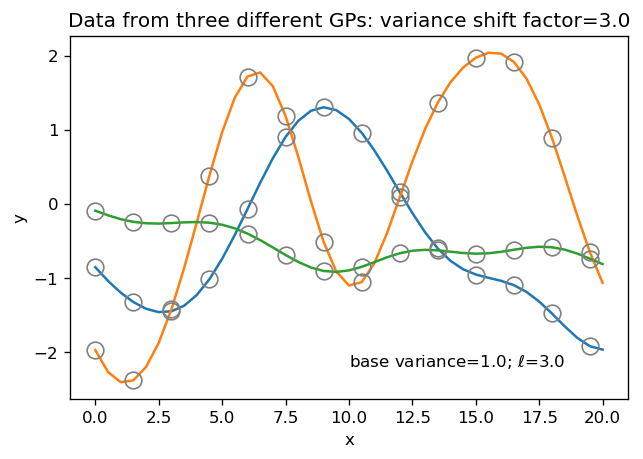

In [7]:
# Instantiate a Gaussian Process model
#Note that we do not return the covariances of the GP for which we generate the data since we decided we should not be using them.
seed=5; toy_data_full_1 = gp1.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_2 = gp2.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_3 = gp3.sample_y(X_full, n_samples=1, random_state=seed).T
#Note also that we switch the seed after each call, to try and get GPs that start at somewhat different points. 

#compute the curves, i.e., the averages of the GPs, and then concatenate everything
mean_full_1 = gp1.predict(X_full)
mean_full_2 = gp2.predict(X_full)
mean_full_3 = gp3.predict(X_full)

toy_data_full = np.concatenate((toy_data_full_1,toy_data_full_2,toy_data_full_3),axis=0)
mean_full = np.concatenate(([mean_full_1],[mean_full_2],[mean_full_3]),axis=0)

#Now we define toy_data, which is the reduction of toy_data_full to the training points. 
toy_data = toy_data_full[:, mask]

#We also define the testing data, the complement of the training set
toy_data_test = toy_data_full[:, ~mask]

#plot the data
plt.title('Data from three different GPs: variance shift factor='+str(varianceshiftfactor))
plt.xlabel('x')
plt.ylabel('y')
string='base variance='+str(basevariance)+'; $\ell$='+str(baselengthscale)
plt.text(10,-2.2,string)
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

Blue curve is the original variance (1), orange has a larger variance, and green a smaller one. 

Now we estimate the hyperparameters of a GP, "gp_fixed" (because its length scale is fixed)
using conjugacy, and fit to the data

In [8]:
kernel= C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#This defines the GP for the start of the fitting. DP shifted this line
#here in order to make sure that we were not inadvertantly talking to 
#the underlying GP.

gp_fixed = ConjugateGaussianProcess(kernel)
gp_fixed.fit(X, toy_data)

#compute the mean and covariance of the underlying, fitted process at the training-set points
fitmean = gp_fixed.mean()
fitcov = gp_fixed.cov()

#compute the mean and covaraince of the underlying process at the set X_test, i.e., the baseline & pattern of fluctuations for 
#the generation of the curves we already computed. This 
fitmean_test = gp_fixed.mean(X_test)
fitcov_test = gp_fixed.cov(X_test,X_test)

#compute the values of the fitted GP at all the data points on all the curves, as well as associated curve-by-curve means & covariances,
#together with the standard deviation of the fitted GP at each of the data points.
m_pred, K_pred = gp_fixed.predict(X_full, return_cov=True, pred_noise=True)
sd_pred = np.sqrt(np.diag(K_pred))

Now we plot the mean and 1-sigma variation of the fitted, underlying GP, together with the three curves we generated from it by fitting to the training data (dashed lines) as well as the curves that constitute the data itself (solid lines).

Underlying GP has mean and standard deviation of: -0.3078856841197638 +/- 1.4450308373875742


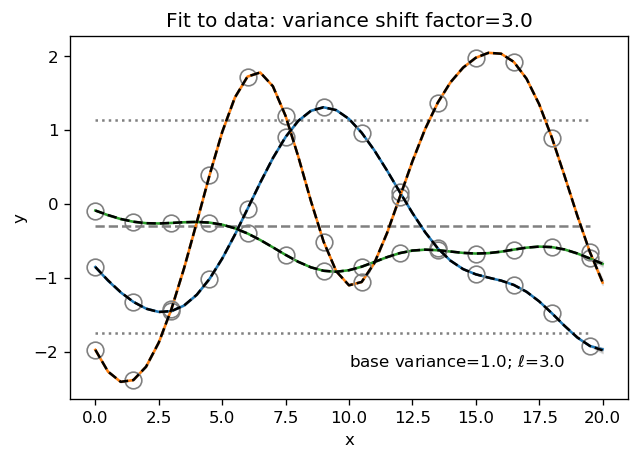

In [9]:
#Define plot text
plt.title('Fit to data: variance shift factor='+str(varianceshiftfactor))
plt.xlabel('x')
plt.ylabel('y')
string='base variance='+str(basevariance)+'; $\ell$='+str(baselengthscale)
plt.text(10,-2.2,string)

# Plot the underlying process
plt.plot(X.ravel(), gp_fixed.mean(), ls='--', c='gray')
plt.plot(X.ravel(), gp_fixed.mean() + gp_fixed.sd(), ls=':', c='gray')
plt.plot(X.ravel(), gp_fixed.mean() - gp_fixed.sd(), ls=':', c='gray');

# Now plot the data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_full.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_full.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
#plt.legend();

print('Underlying GP has mean and standard deviation of:',gp_fixed.mean()[1],'+/-',gp_fixed.sd())

The standard deviation comes out a bit larger than one, which seems to be generic. The one-sigma band is indicated by the dotted line. The mean (indicated by dashed line) is not quite the same as the mean of the three processes used to generate data, but is consistent within errors. The interpolants seem to do very well. Their two-sigma error bands are not visible on this scale.

### Learning the length scale for this first example

Now we will do the length-scale learning for this first medium-variance-shift case.

First, we define the gp and generate the likelihood for the length scale on a mesh. Note that for the latter we need to add a nugget in order to make the necessary matrix inversions stable. 

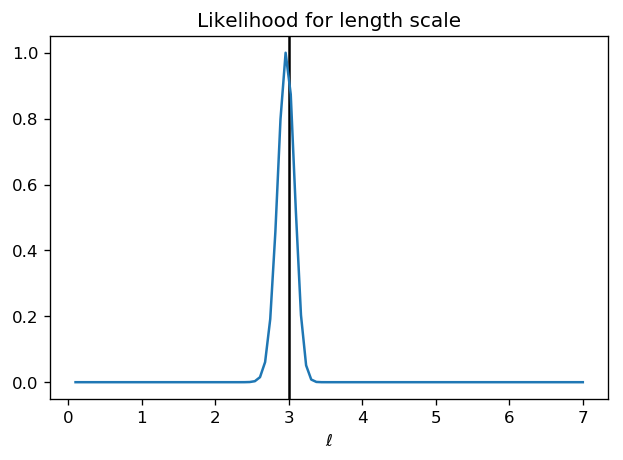

In [10]:
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])

Rs = np.array([rbf(X, X, ls=L) + nugget_sd**2 * np.eye(X.shape[0]) for L in ls_mesh ])

ls_loglike = gp.likelihood(log=True, X=X, y=toy_data, corr=Rs)
ls_like = np.exp(ls_loglike - np.max(ls_loglike))

ax = plt.gca()
ax.set_xlabel(r'$\ell$')
ax.set_title('Likelihood for length scale')
ax.axvline(baselengthscale, 0, 1, c='k')
ax.plot(ls_mesh, ls_like);

The MAP value is out a little bit, but not disturbingly, low. The correct length scale, indicated by the solid line is certainly something that has a high probability. 

Now we ascertain what that number is through likelihood maximization and so define the GP at that length scale.

In [11]:
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

Setting kernel kwargs to {'ls': 2.957575757575758}


Note that peak of likelihood is actually at 2.967, but one needs 800 points in this particular mesh to get the third significant figure, and several thousand to get the fourth. We stick with 100 for now, which still gives the correct peak to better than 0.5%.

Note also the consistency of the number MAP value with the above plot.

And now we ompute means & covariances of that GP at testing and training points

In [12]:
mean_est, cov_est = gp.mean(), gp.cov()
fitmean_test, fitcov_test = gp.mean(X_test), gp.cov(X_test,X_test) 

We now use the output of the fit to define a "static" GP, which does not update the fit every time it sees new data, but just takes the mode of the length scale pdf as its length scale. This is what we will pass in circumstances where fitting might alter the definition of "gp". 

In [13]:
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)

Now it's time to finally use some Bastos & O'Hagan diagnostics with this best-fit GP. First, compare to the training data: this is non-trivial, because we are fitting one GP to three different data sets, and they may not be (actually they are not!) representable as draws from one process, with a single length scale & variance.

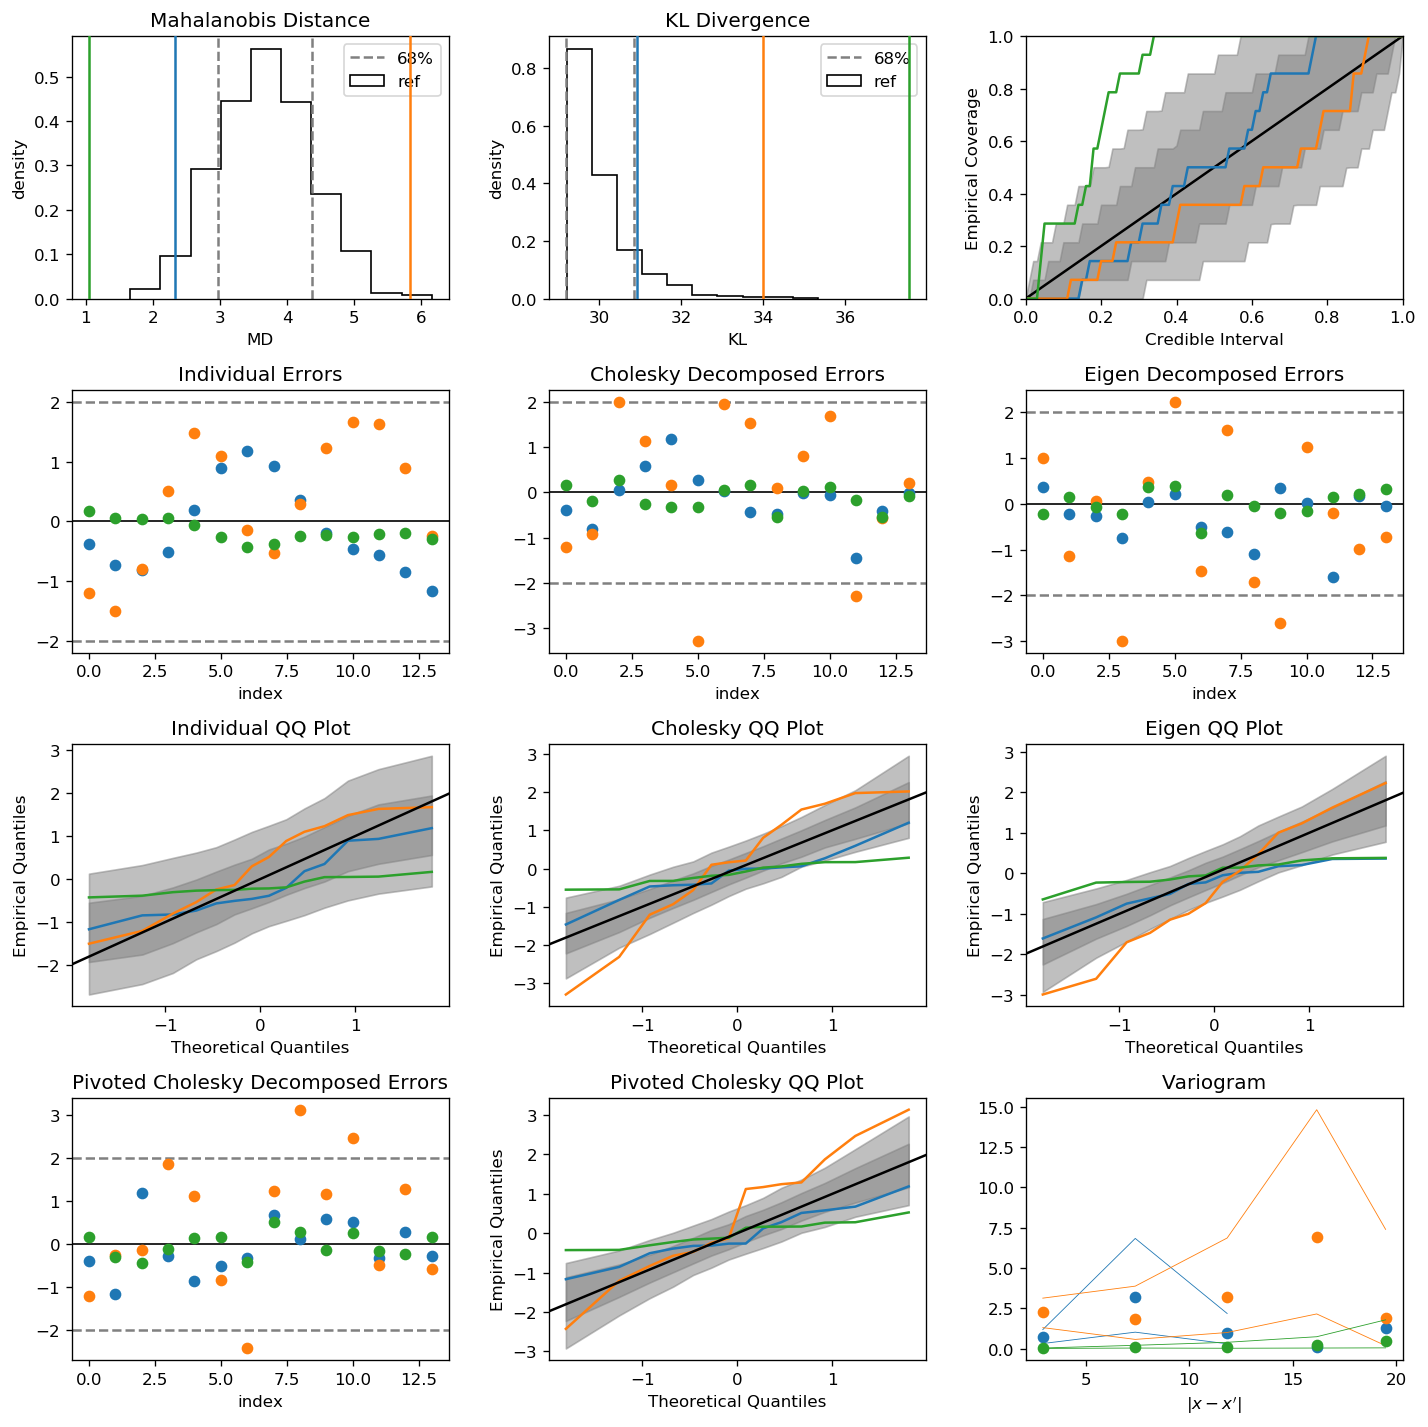

In [14]:
gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

**Observations:**<br>
There are too many green errors that are too small and too many orange errors that are too big: see PC QQ plot. <br>
This shows up in the Mahalanobis distances. <br>
Green DCI plot goes a bit crazy: too much winning. <br>

But the utility of this is limited by the small number of data. So we turn our attention to the testing data.

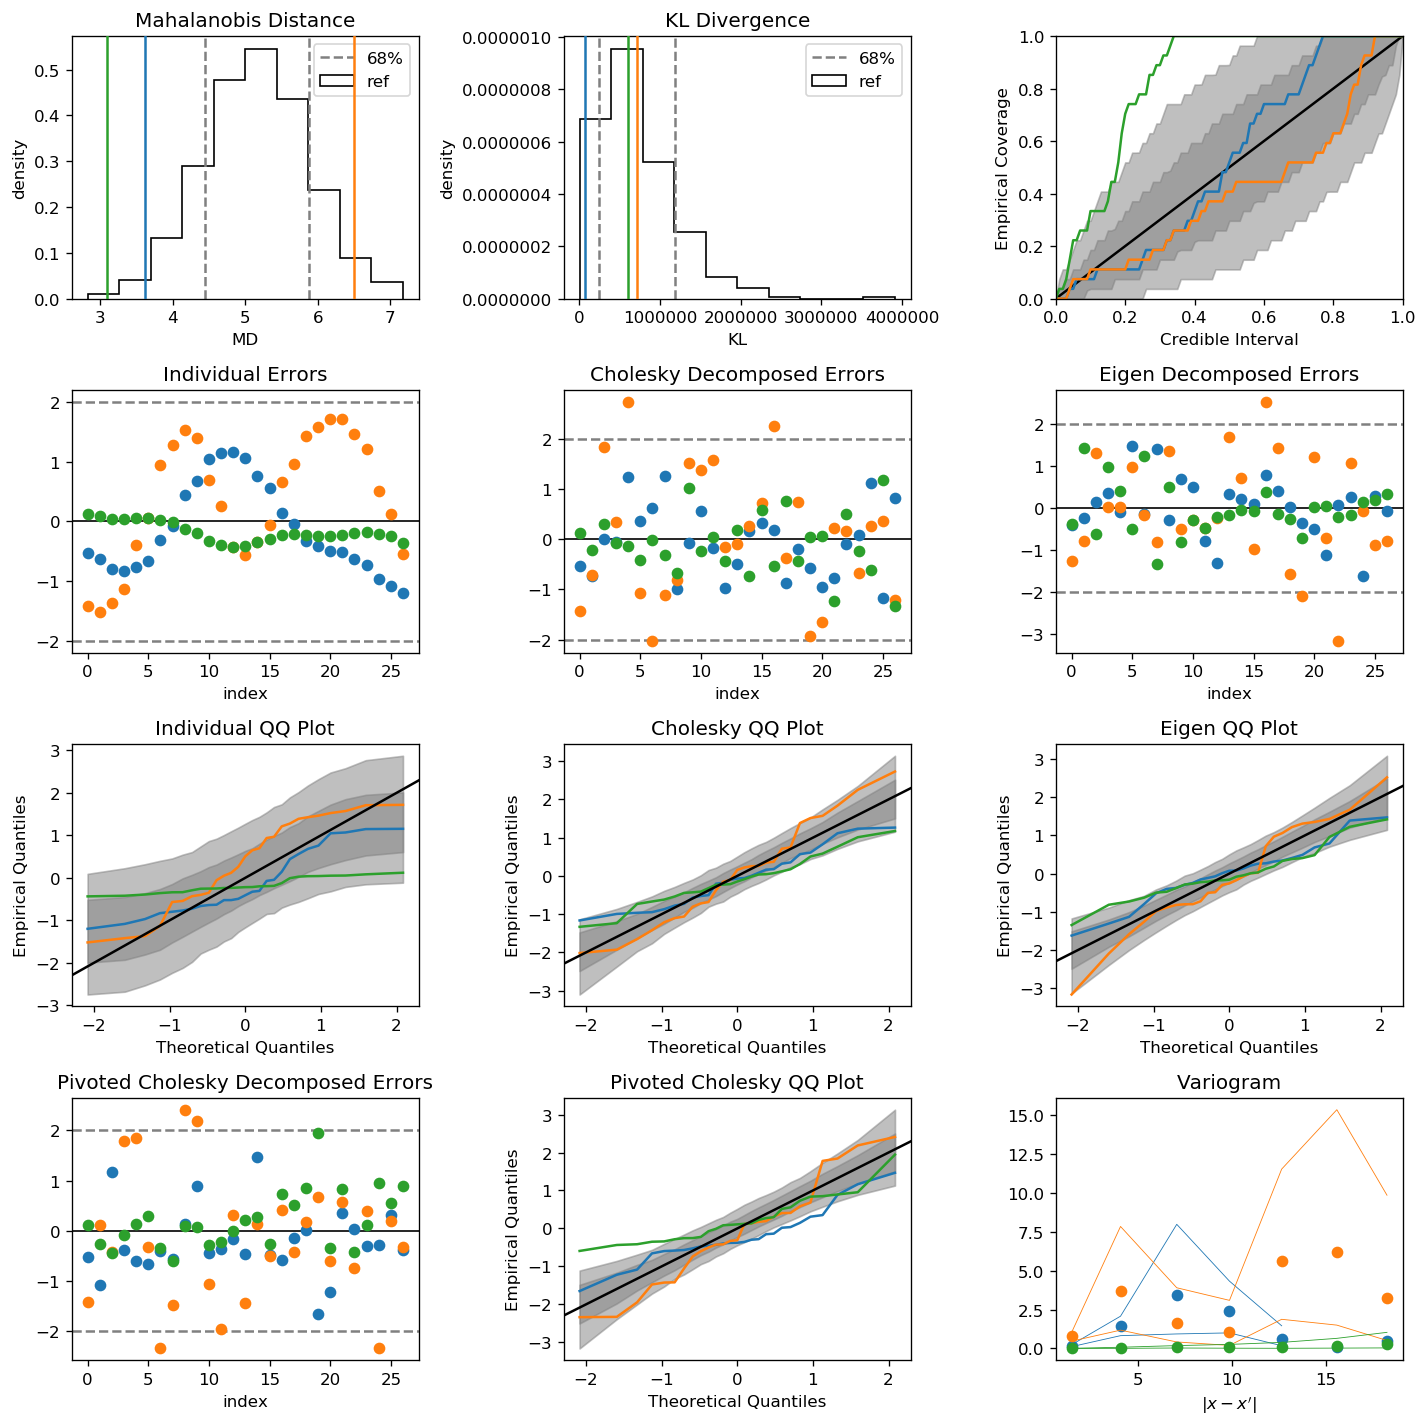

In [15]:
gpmc_test = Diagnostic(fitmean_test, fitcov_test + nugget_sd**2 * np.eye(fitcov_test.shape[0]))
gd_test = GraphicalDiagnostic(gpmc_test, toy_data_test, nref=n_ref)
gd_test.plotzilla(X_test, gp_static, vlines=vlines);

**Observations:**<br>
Green & orange MDs recover somewhat cf. the results from the training set.<br>
DCI plot for green reveals problems. <br>
Problems with variance show up at low index in PC decomposed errors and high index in eigen decomposed errors for green & (maybe?) orange. (3 out of first 13 PC errors > 2 sigma for orange curve.)<br> 
Blue looks fine there, but close comparison, also on QQ plot, reveals its error structure is a little bit off (cf. also next example below).<br>
The QQ plots sort-of show these issues, but the only place they are outside 2-sigma is in the low-quantile portion of the green plot. <br>

This behaviour of the QQ plot seems rather generic and is presumably because the signal from the low-index PC errors gets a bit washed out by the high-index PC errors, which are fine. 

What about the interpolants?

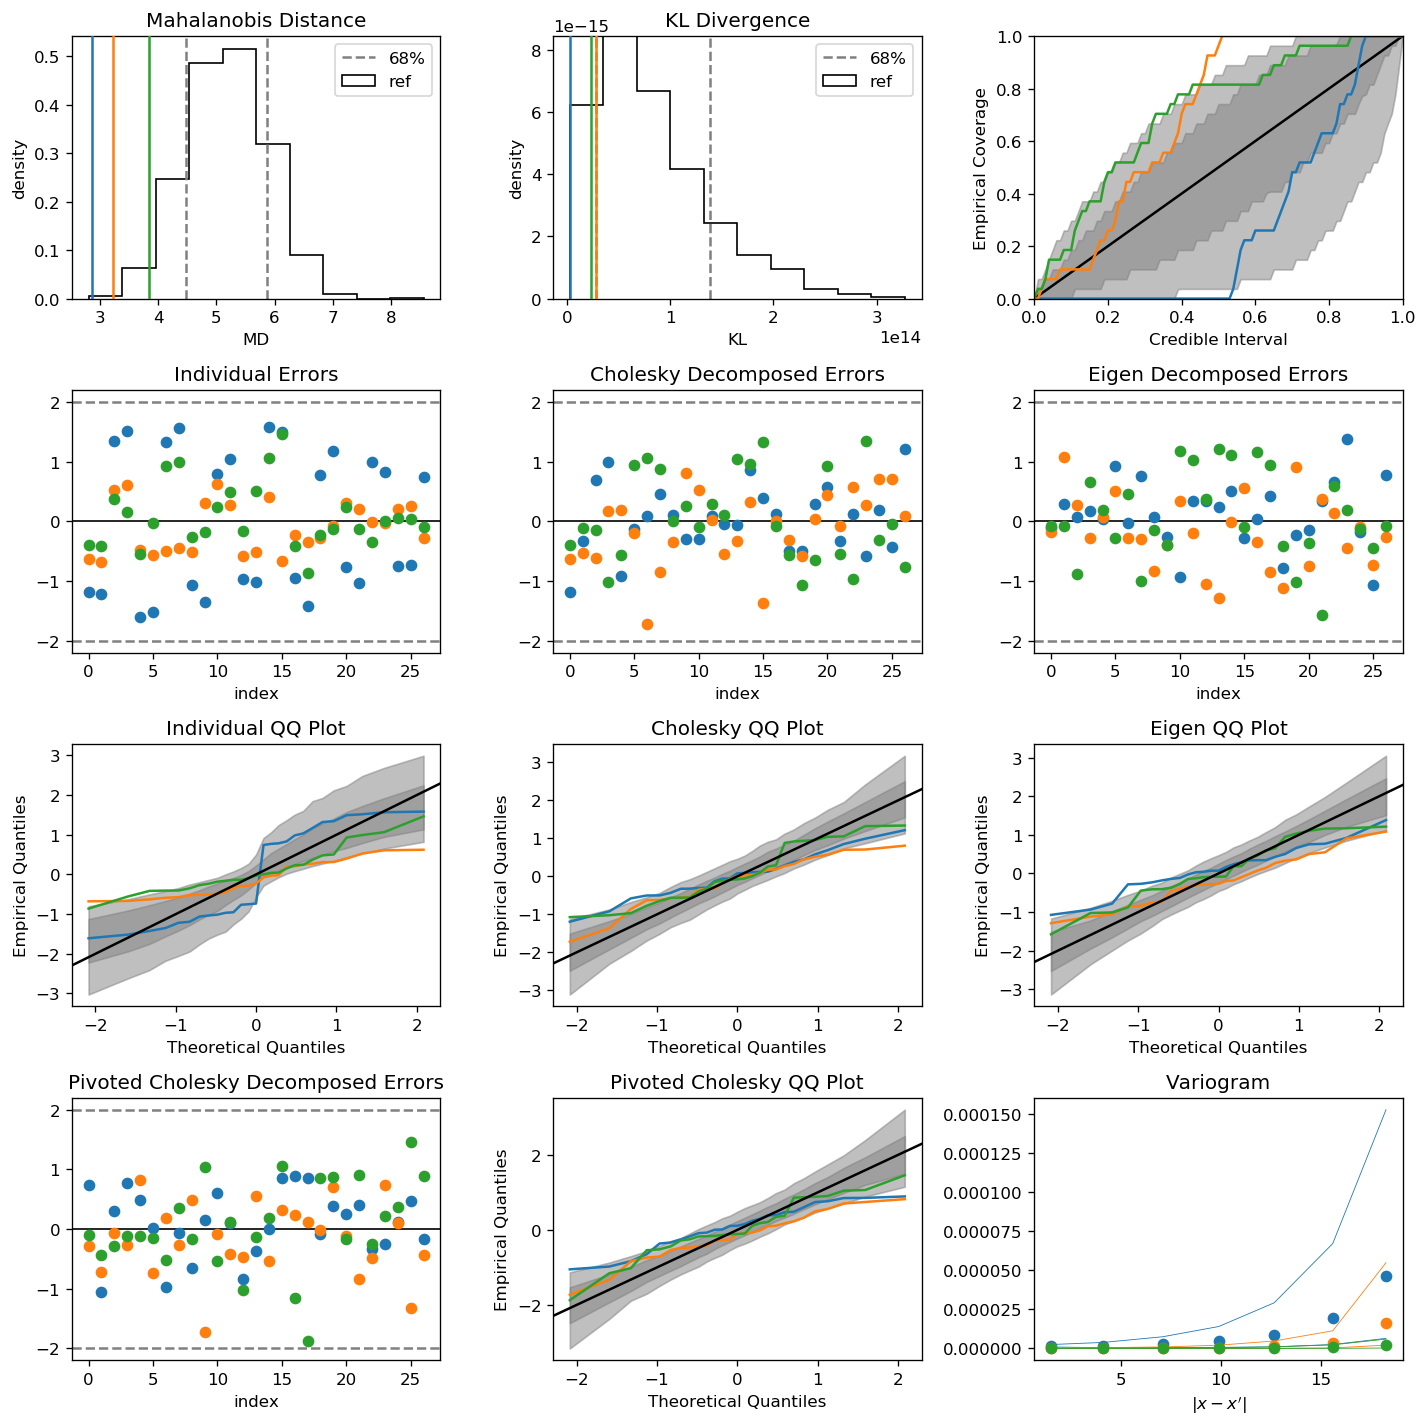

In [16]:
mean_test, cov_test = gp.predict(X_test, return_cov=True, pred_noise=True)
#make sure we are computing the mean & covariance of the "best fit" GP, and not the one defined above with the fixed length scsale

gpmc = Diagnostic(np.zeros(mean_test.shape[1]), cov_test + nugget_sd**2 * np.eye(cov_test.shape[0]))
gd = GraphicalDiagnostic(gpmc, toy_data_test-mean_test, nref=n_ref)
gd.plotzilla(X_test, gp_static, vlines=vlines);

The interpolants seem to work too well for all three data sets. All the QQ plots go under the diagonal line at high quantiles. Note that there is some weirdness with the blue data at low quantiles, which shows up in the DCI plot. Somehow none of the blue individual errors is _really_ small, but all of them are less than 2 sigma. Although this low-quantile issue for the blue data is ameliorated once we account for correlations it still appears in, e.g., the PC QQ plot. 

## Second example, with a different noise
Now we try with a different seed, to see what changes and what doesn't

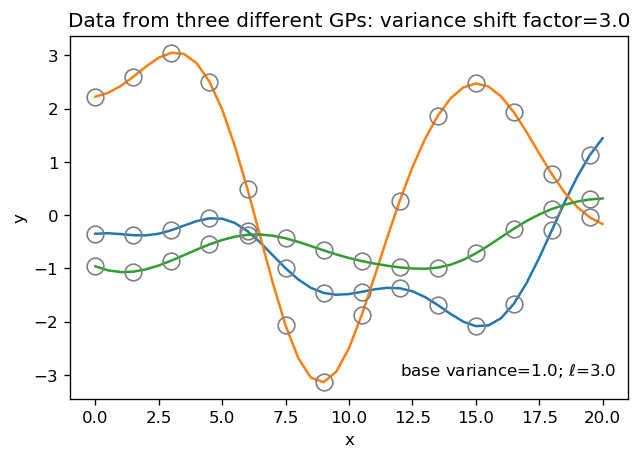

In [17]:
#Define the model that will produce the data
seed=1; toy_data_full_1 = gp1.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_2 = gp2.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_3 = gp3.sample_y(X_full, n_samples=1, random_state=seed).T

#compute the curves, i.e., the averages of the GPs, and then concatenate everything
mean_full_1 = gp1.predict(X_full)
mean_full_2 = gp2.predict(X_full)
mean_full_3 = gp3.predict(X_full)

toy_data_full = np.concatenate((toy_data_full_1,toy_data_full_2,toy_data_full_3),axis=0)
mean_full = np.concatenate(([mean_full_1],[mean_full_2],[mean_full_3]),axis=0)

#Now we define toy_data, which is the reduction of toy_data_full to the training points. 
toy_data = toy_data_full[:, mask]

#We also define the testing data, the complement of the training set
toy_data_test = toy_data_full[:, ~mask]

#plot the data
plt.title('Data from three different GPs: variance shift factor='+str(varianceshiftfactor))
plt.xlabel('x')
plt.ylabel('y')
string='base variance='+str(basevariance)+'; $\ell$='+str(baselengthscale)
plt.text(12,-3.0,string)
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

Remember: blue curve is the original variance (1), orange has a larger variance, and green a smaller one. 

Once again, estimate the hyperparameters other than length scale using conjugacy, and fit to the data, we get the plot shown below:

In [18]:
kernel= C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#This defines the GP for the start of the fitting. DP shifted this line
#here in order to make sure that we were not inadvertantly talking to 
#the underlying GP.

gp_fixed = ConjugateGaussianProcess(kernel)
gp_fixed.fit(X, toy_data)

#compute the mean and covariance of the underlying, fitted process at the training-set points
fitmean = gp_fixed.mean()
fitcov = gp_fixed.cov()

#compute the mean and covaraince of the underlying process at the set X_test, i.e., the baseline & pattern of fluctuations for 
#the generation of the curves we already computed. This 
fitmean_test = gp_fixed.mean(X_test)
fitcov_test = gp_fixed.cov(X_test,X_test)

#compute the values of the fitted GP at all the data points on all the curves, as well as associated curve-by-curve means & covariances,
#together with the standard deviation of the fitted GP at each of the data points.
m_pred, K_pred = gp_fixed.predict(X_full, return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

Underlying GP has mean and standard deviation of: 0.017843282454017985 +/- 1.5048707318480397


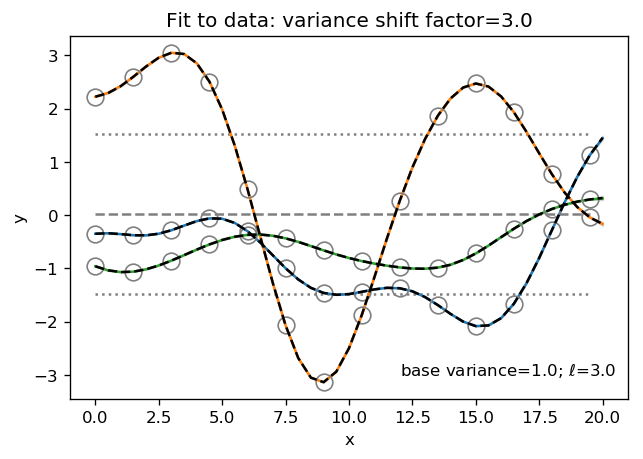

In [19]:
#Define plot text
plt.title('Fit to data: variance shift factor='+str(varianceshiftfactor))
plt.xlabel('x')
plt.ylabel('y')
string='base variance='+str(basevariance)+'; $\ell$='+str(baselengthscale)
plt.text(12,-3.0,string)

# Plot the underlying process
plt.plot(X.ravel(), gp_fixed.mean(), ls='--', c='gray')
plt.plot(X.ravel(), gp_fixed.mean() + gp_fixed.sd(), ls=':', c='gray')
plt.plot(X.ravel(), gp_fixed.mean() - gp_fixed.sd(), ls=':', c='gray');

# Now plot the data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_full.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_full.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
#plt.legend();

print('Underlying GP has mean and standard deviation of:',gp_fixed.mean()[1],'+/-',gp_fixed.sd())

The standard deviation again comes out a bit larger than one. But the interpolants look very good. Again.

### Learning the length scale for this second example

Now we will do the length-scale learning for this medium-variance-shift case

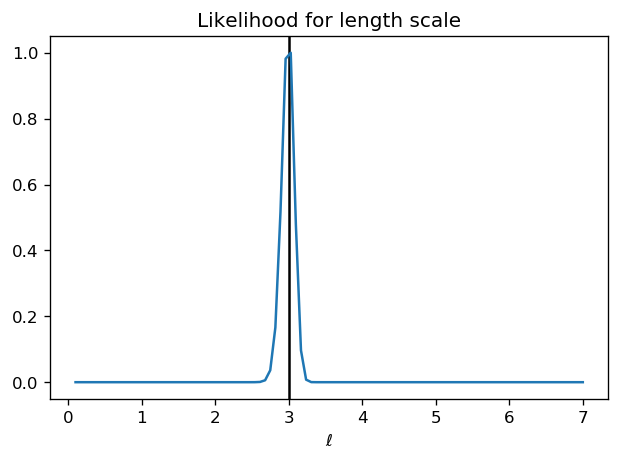

In [20]:
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])

Rs = np.array([rbf(X, X, ls=L) + nugget_sd**2 * np.eye(X.shape[0]) for L in ls_mesh ])

ls_loglike = gp.likelihood(log=True, X=X, y=toy_data, 

corr=Rs)
ls_like = np.exp(ls_loglike - np.max(ls_loglike))

ax = plt.gca()
ax.set_xlabel(r'$\ell$')
ax.set_title('Likelihood for length scale')
ax.axvline(baselengthscale, 0, 1, c='k')
ax.plot(ls_mesh, ls_like);

In [21]:
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

Setting kernel kwargs to {'ls': 3.027272727272728}


Now compute the means and covarainces for this best fit process, and launch the diagnostic for the training set

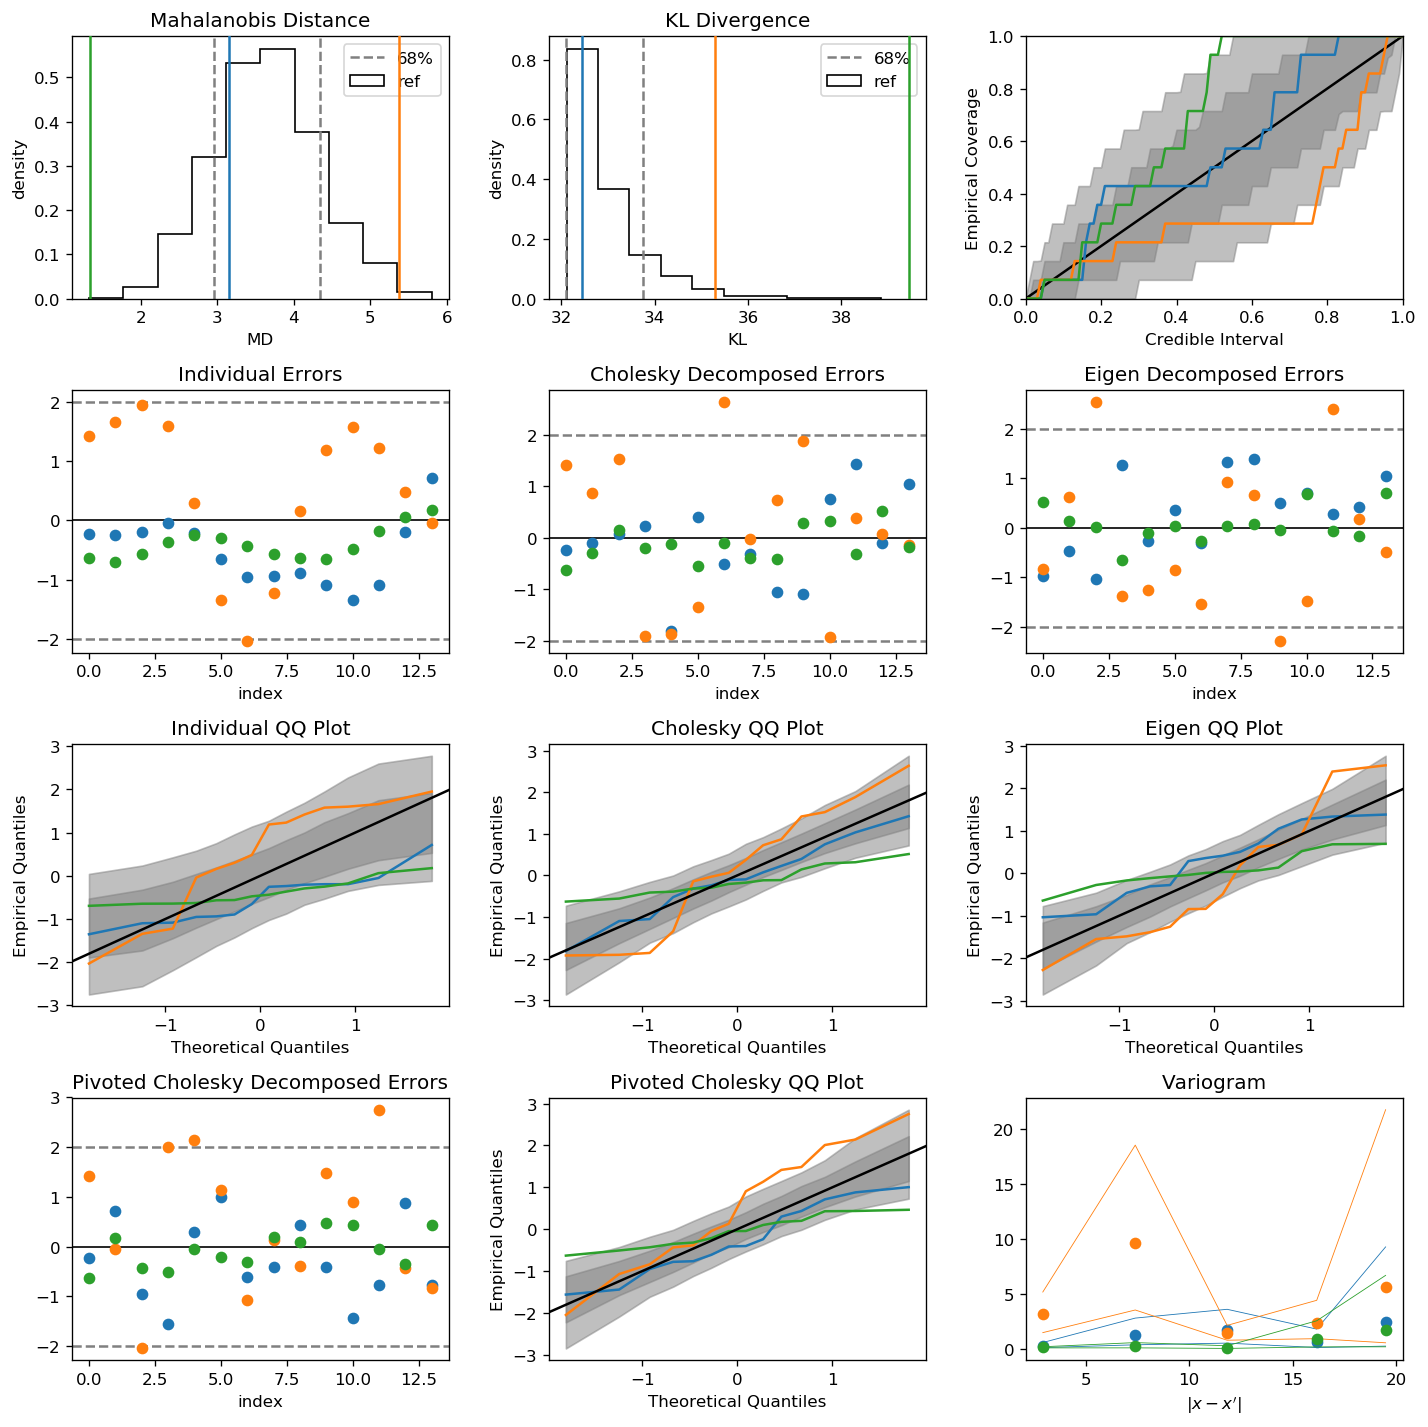

In [22]:
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.mean(), gp.cov()
fitmean_test = gp.mean(X_test) 
fitcov_test = gp.cov(X_test,X_test) 

gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

**Observations:**<br>
Here the comparison to the training set manifests more problems than for the first data set, above.<br>
Green & orange MDs further away;<br>
Significantly too many > 2 sigma PC errors for orange, as shown in QQ plot;<br>
Significantly too many < 1 sigma PC errors for green, as shown in QQ plot.<br>
(As usual these last two features also show up in the eigen error diagnostics.)

Now it's time for the testing data comparison

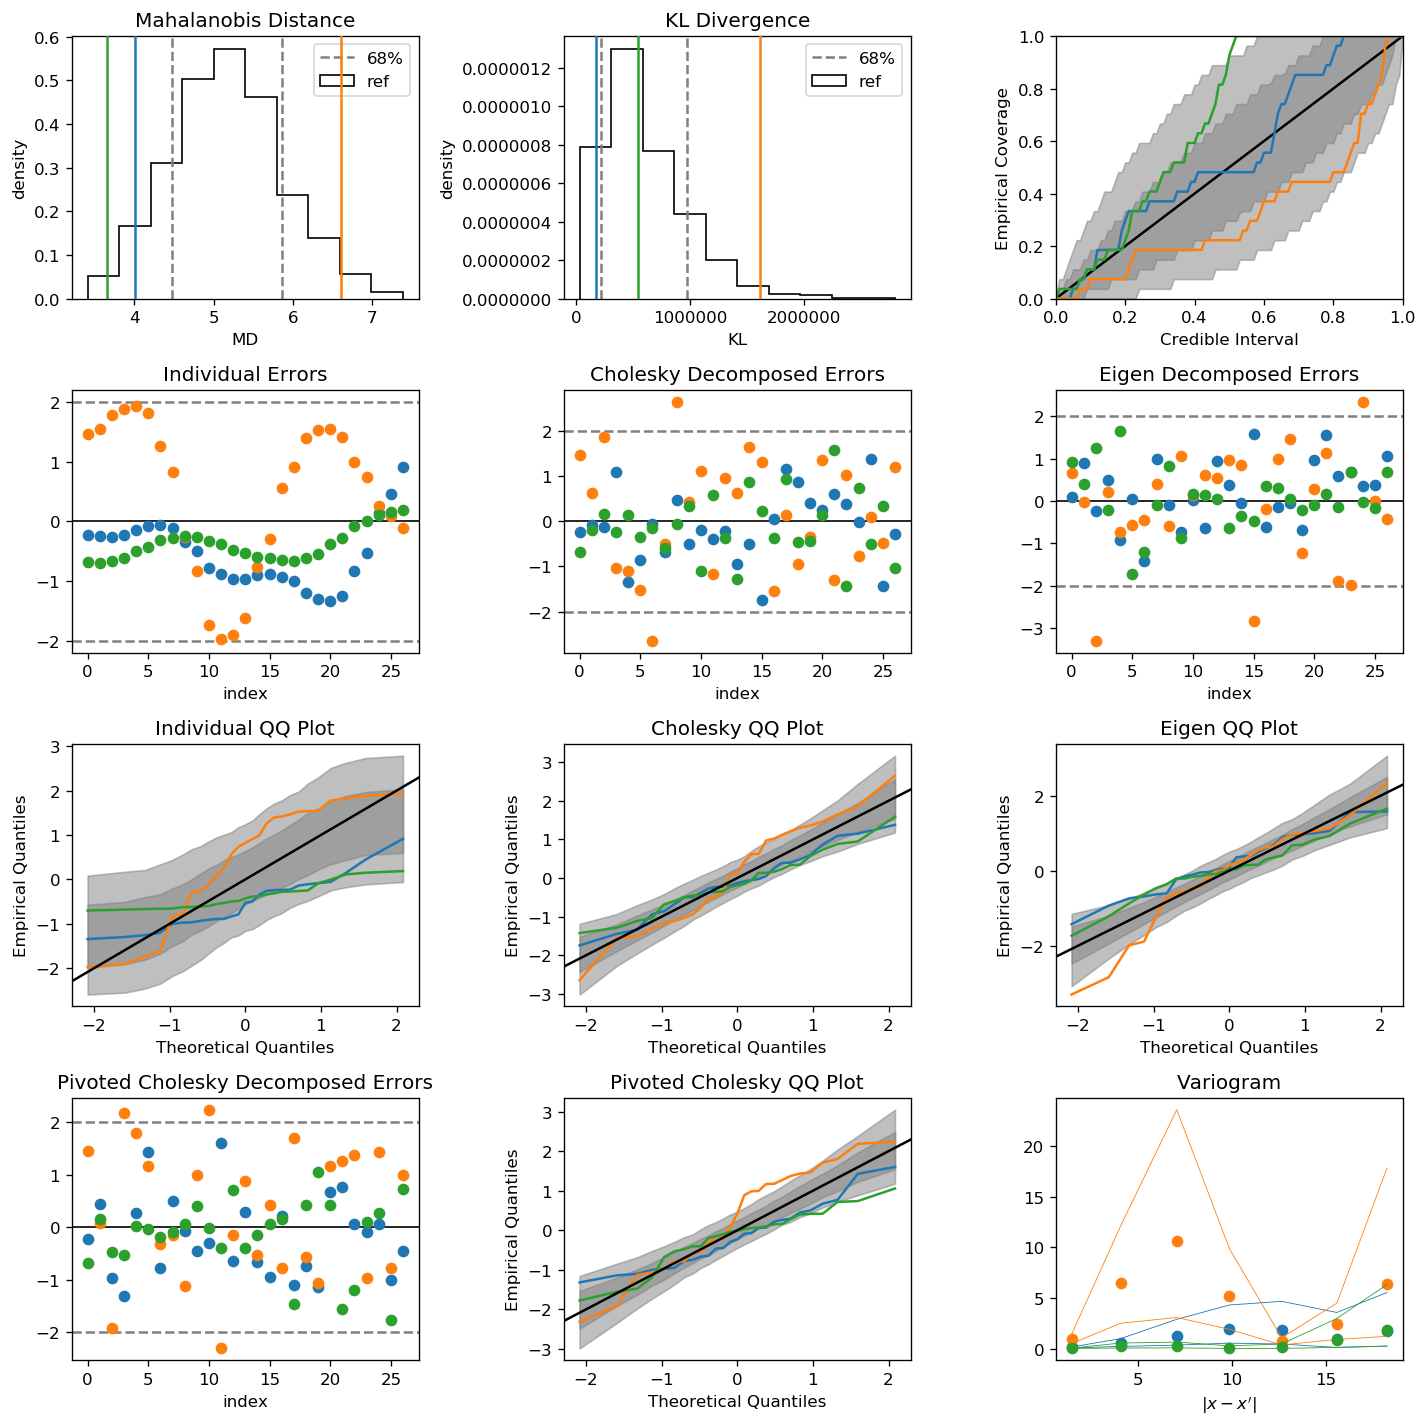

In [23]:
gpmc_test = Diagnostic(fitmean_test, fitcov_test + nugget_sd**2 * np.eye(fitcov_test.shape[0]))
gd_test = GraphicalDiagnostic(gpmc_test, toy_data_test, nref=n_ref)
gd_test.plotzilla(X_test, gp_static, vlines=vlines);

**Observations:**<br>
MD for orange curve is again too large.<br>
DCI plot does show problems for green though.<br>
Eigen decomposed errors again show structure: errors are too large (small) at high index for orange (green).<br>
Pivoted Cholesky errors from index 1-13 show similar issues to eigen errors at large index.<br> 
PC QQ plot has orange errors "on the edge". <br>
It's noticeable there that the blue errors don't have the correct QQ-plot slope, and that shows up in the eigen-error QQ plot too. 

This last could be a consequence of comparing data generated with a variance of 1 to a GP with a variance of 2.25. 
The blue PC errors are just too small.

Interpolants diagnostics show:

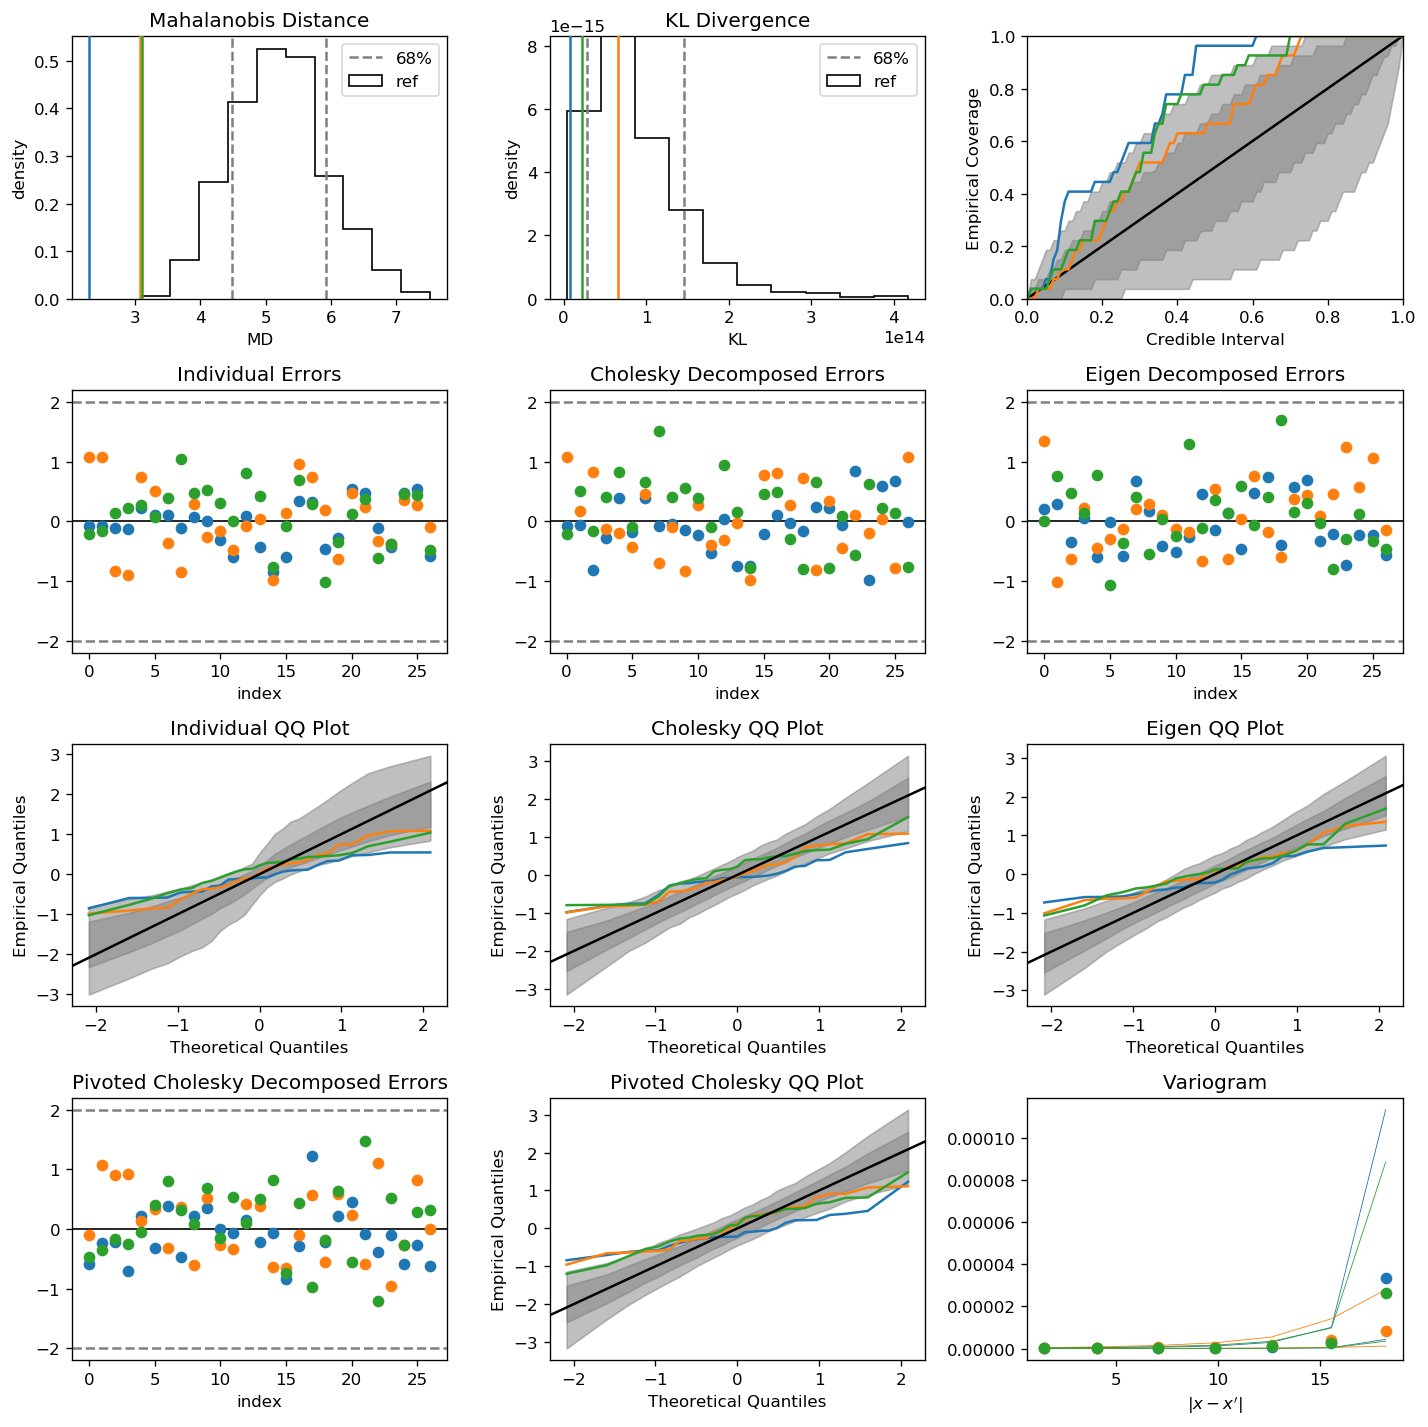

In [24]:
mean_test, cov_test = gp.predict(X_test, return_cov=True, pred_noise=True)
#make sure we are computing the mean & covariance of the "best fit" GP, and not gp_fixed defined above with the fixed length scsale

gpmc = Diagnostic(np.zeros(mean_test.shape[1]), cov_test + nugget_sd**2 * np.eye(cov_test.shape[0]))
gd = GraphicalDiagnostic(gpmc, toy_data_test-mean_test, nref=n_ref)
gd.plotzilla(X_test, gp_static, vlines=vlines);

Interpolants are once again "all too good".

## A third noise choice
Now we try with y.a. seed, to see what changes and what doesn't

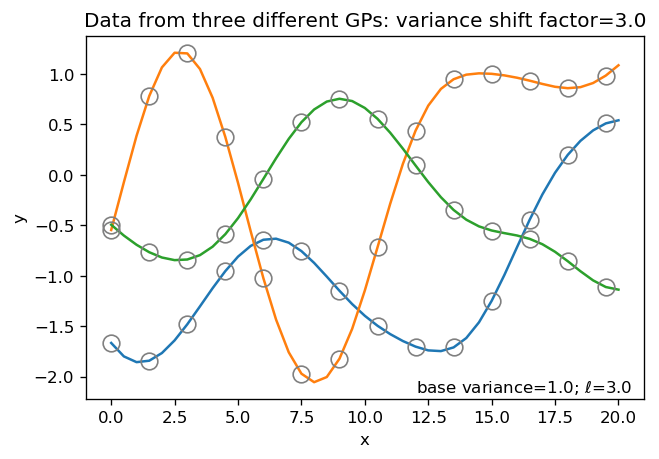

In [25]:
#define the model that will produce the data
seed=3; toy_data_full_1 = gp1.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_2 = gp2.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_3 = gp3.sample_y(X_full, n_samples=1, random_state=seed).T

#compute the curves, i.e., the averages of the GPs, and then concatenate everything
mean_full_1 = gp1.predict(X_full)
mean_full_2 = gp2.predict(X_full)
mean_full_3 = gp3.predict(X_full)

toy_data_full = np.concatenate((toy_data_full_1,toy_data_full_2,toy_data_full_3),axis=0)
mean_full = np.concatenate(([mean_full_1],[mean_full_2],[mean_full_3]),axis=0)

#Now we define toy_data, which is the reduction of toy_data_full to the training points. 
toy_data = toy_data_full[:, mask]

#We also define the testing data, the complement of the training set
toy_data_test = toy_data_full[:, ~mask]

#plot the data
plt.title('Data from three different GPs: variance shift factor='+str(varianceshiftfactor))
plt.xlabel('x')
plt.ylabel('y')
string='base variance='+str(basevariance)+'; $\ell$='+str(baselengthscale)
plt.text(12,-2.15,string)
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

Remember: blue curve is the original variance (1), orange has a larger variance, and green a smaller one. 

Once again, estimate the hyperparameters using conjugacy, and fit to the data. Then generate the plot.

In [26]:
kernel= C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#This defines the GP for the start of the fitting. DP shifted this line
#here in order to make sure that we were not inadvertantly talking to 
#the underlying GP.

gp_fixed = ConjugateGaussianProcess(kernel)
gp_fixed.fit(X, toy_data)

#compute the mean and covariance of the underlying, fitted process at the training-set points
fitmean = gp_fixed.mean()
fitcov = gp_fixed.cov()

#compute the mean and covaraince of the underlying process at the set X_test, i.e., the baseline & pattern of fluctuations for 
#the generation of the curves we already computed. This 
fitmean_test = gp_fixed.mean(X_test)
fitcov_test = gp_fixed.cov(X_test,X_test)

#compute the values of the fitted GP at all the data points on all the curves, as well as associated curve-by-curve means & covariances,
#together with the standard deviation of the fitted GP at each of the data points.
m_pred, K_pred = gp_fixed.predict(X_full, return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

Underlying GP has mean and standard deviation of: -0.32135230388917524 +/- 0.9690651695500073


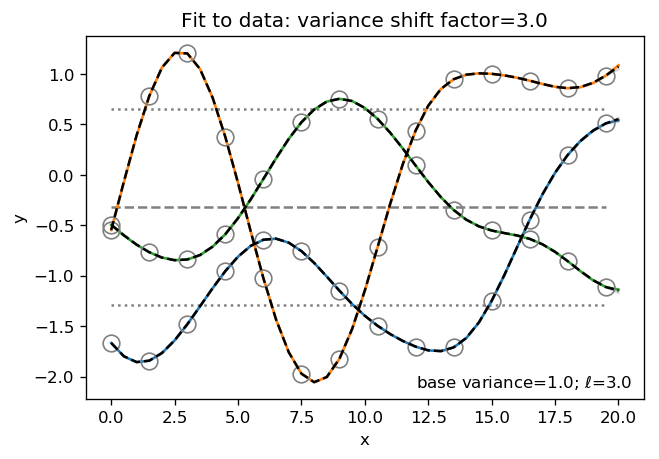

In [27]:
#Define plot text
plt.title('Fit to data: variance shift factor='+str(varianceshiftfactor))
plt.xlabel('x')
plt.ylabel('y')
string='base variance='+str(basevariance)+'; $\ell$='+str(baselengthscale)
plt.text(12,-2.1,string)

# Plot the underlying process
plt.plot(X.ravel(), gp_fixed.mean(), ls='--', c='gray')
plt.plot(X.ravel(), gp_fixed.mean() + gp_fixed.sd(), ls=':', c='gray')
plt.plot(X.ravel(), gp_fixed.mean() - gp_fixed.sd(), ls=':', c='gray');

# Now plot the data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_full.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_full.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
#plt.legend();

print('Underlying GP has mean and standard deviation of:',gp_fixed.mean()[1],'+/-',gp_fixed.sd())

This time the standard deviation is a little bit smaller than 1 but the mean is somewhat different from zero. How will this affect the diagnostics? But first...the length scale.

## Learning the length scale: medium-variance-shift case, y.a. seed

We now do length-scale learning for this third medium-variance-shift case and generate and plot the likelihood:

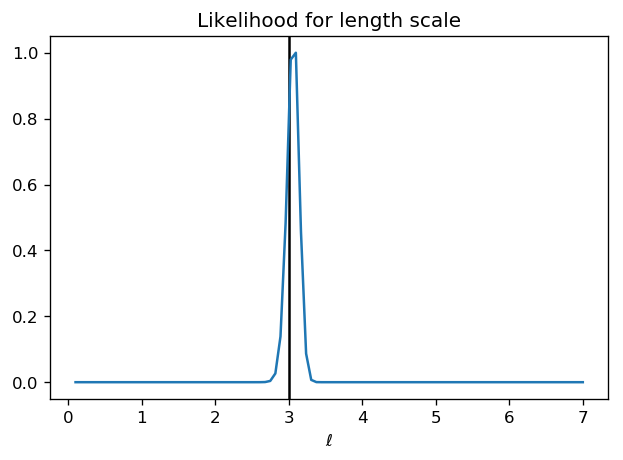

In [28]:
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])

Rs = np.array([rbf(X, X, ls=L) + nugget_sd**2 * np.eye(X.shape[0]) for L in ls_mesh ])

ls_loglike = gp.likelihood(log=True, X=X, y=toy_data, corr=Rs)
ls_like = np.exp(ls_loglike - np.max(ls_loglike))

ax = plt.gca()
ax.set_xlabel(r'$\ell$')
ax.set_title('Likelihood for length scale')
ax.axvline(baselengthscale, 0, 1, c='k')
ax.plot(ls_mesh, ls_like);

In [29]:
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

Setting kernel kwargs to {'ls': 3.096969696969697}


Length scale is about 3% too big now, but the correct length scale is still nice and probable. 

Use the best fit to generate diagnostics on the training set.

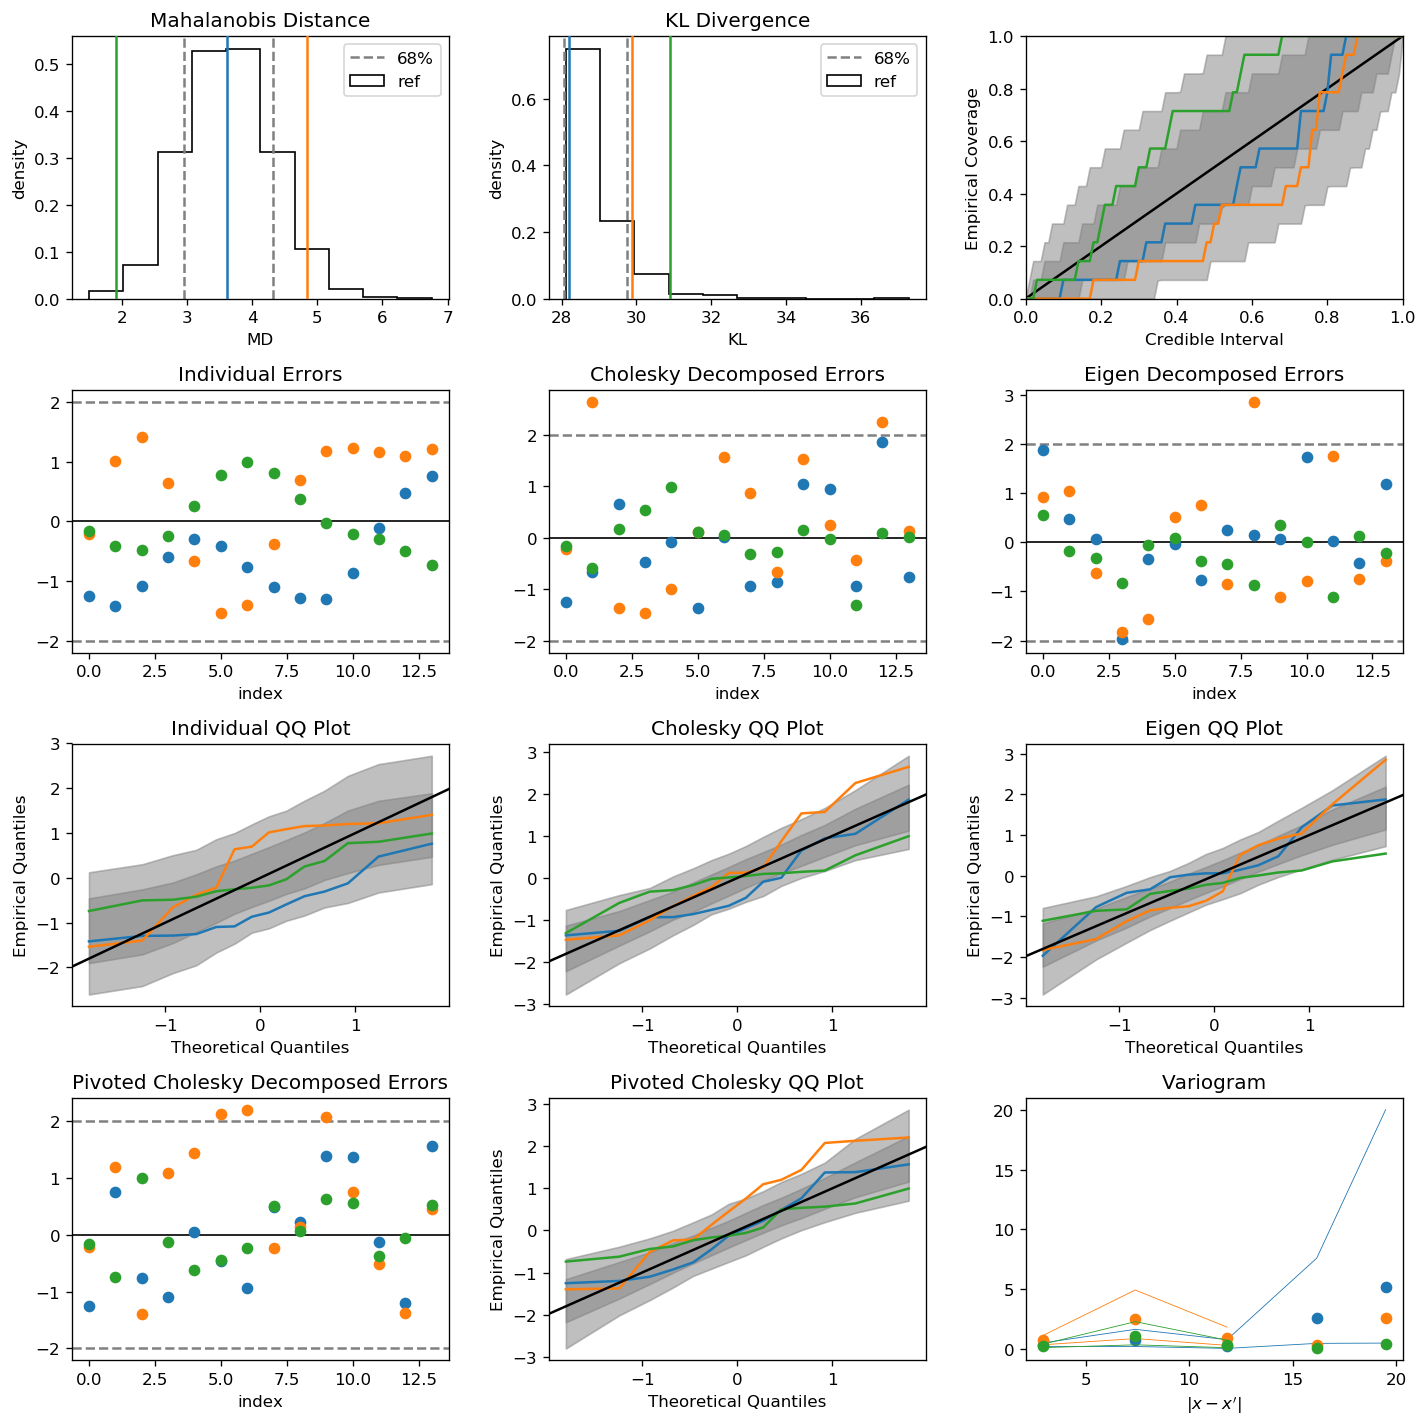

In [30]:
# Don't update the fit everytime we have new data, but use that best fit value everywhere from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.mean(), gp.cov()
fitmean_test=gp.mean(X_test)
fitmean_cov=gp.cov(X_test,X_test)

gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

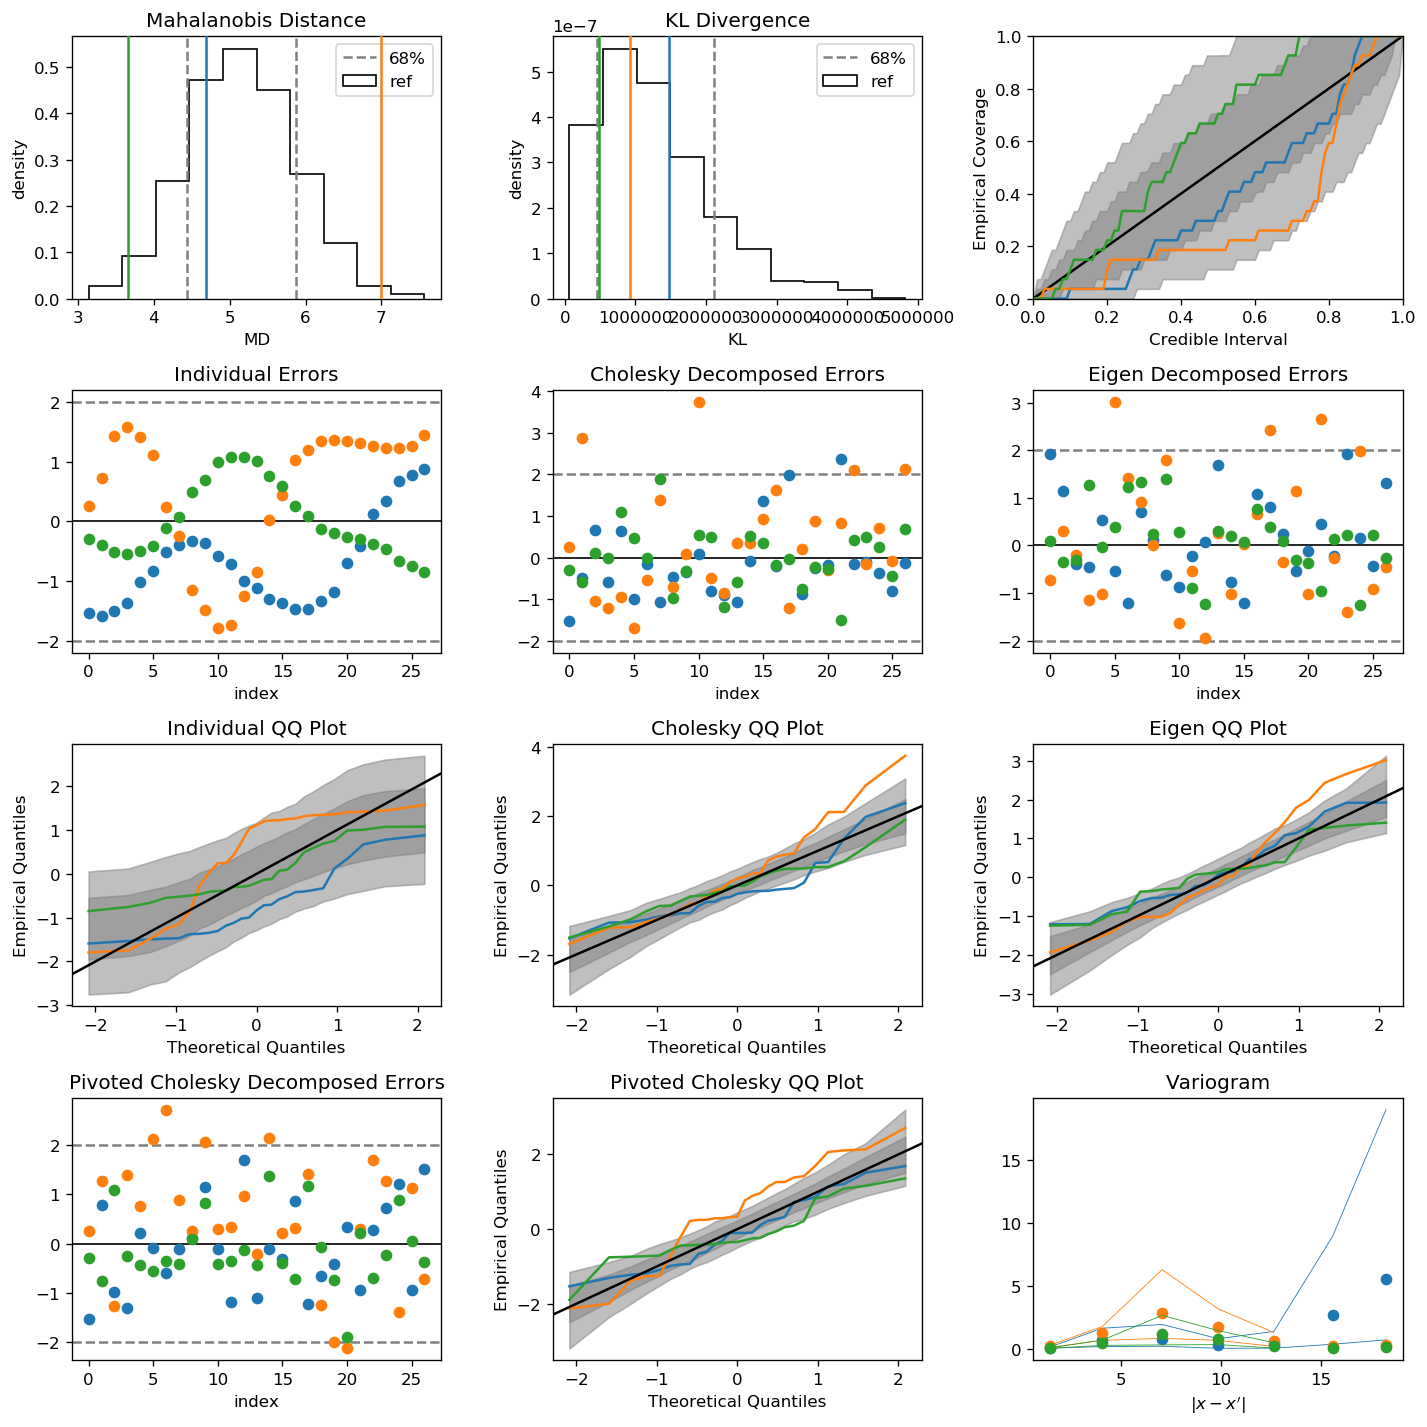

In [31]:
gpmc_test = Diagnostic(fitmean_test, fitcov_test + nugget_sd**2 * np.eye(fitcov_test.shape[0]))
gd_test = GraphicalDiagnostic(gpmc_test, toy_data_test, nref=n_ref)
gd_test.plotzilla(X_test, gp_static, vlines=vlines);

**Observations:**
MD for orange curve is again too large, that for green is too small; <br>
DCI plot  shows problems for green; <br>
Eigen decomposed errors again show structure: errors are too large (small) at high index for orange (green), although this is marginal for orange. <br>
Pivoted Cholesky errors from index 1-13 show similar issues to eigen-errors at large index. Is orange failure more obvious here?<br>
PC QQ plot has too many orange errors that are too large (four > 2 sigma before index 15), and too many green errors that are too small.<br>
The same issues show up in the eigen error QQ plot.<br>
This emphasizes how the QQ plots and the plot vs. index have complementary information.

Compared to cases with significant length-scale misestimation there does not seem to be anything untoward going on in the diagnostics. This encourages us that we can separate length-scale misestimation from variance misestimation.

Note that fact that standard deviation of underlying GP is 0.96 (and not 1.5) allows orange failure to become (somewhat?) apparent here. These plots are "more orange-green symmetric" than previous cases.

Now interpolants again.

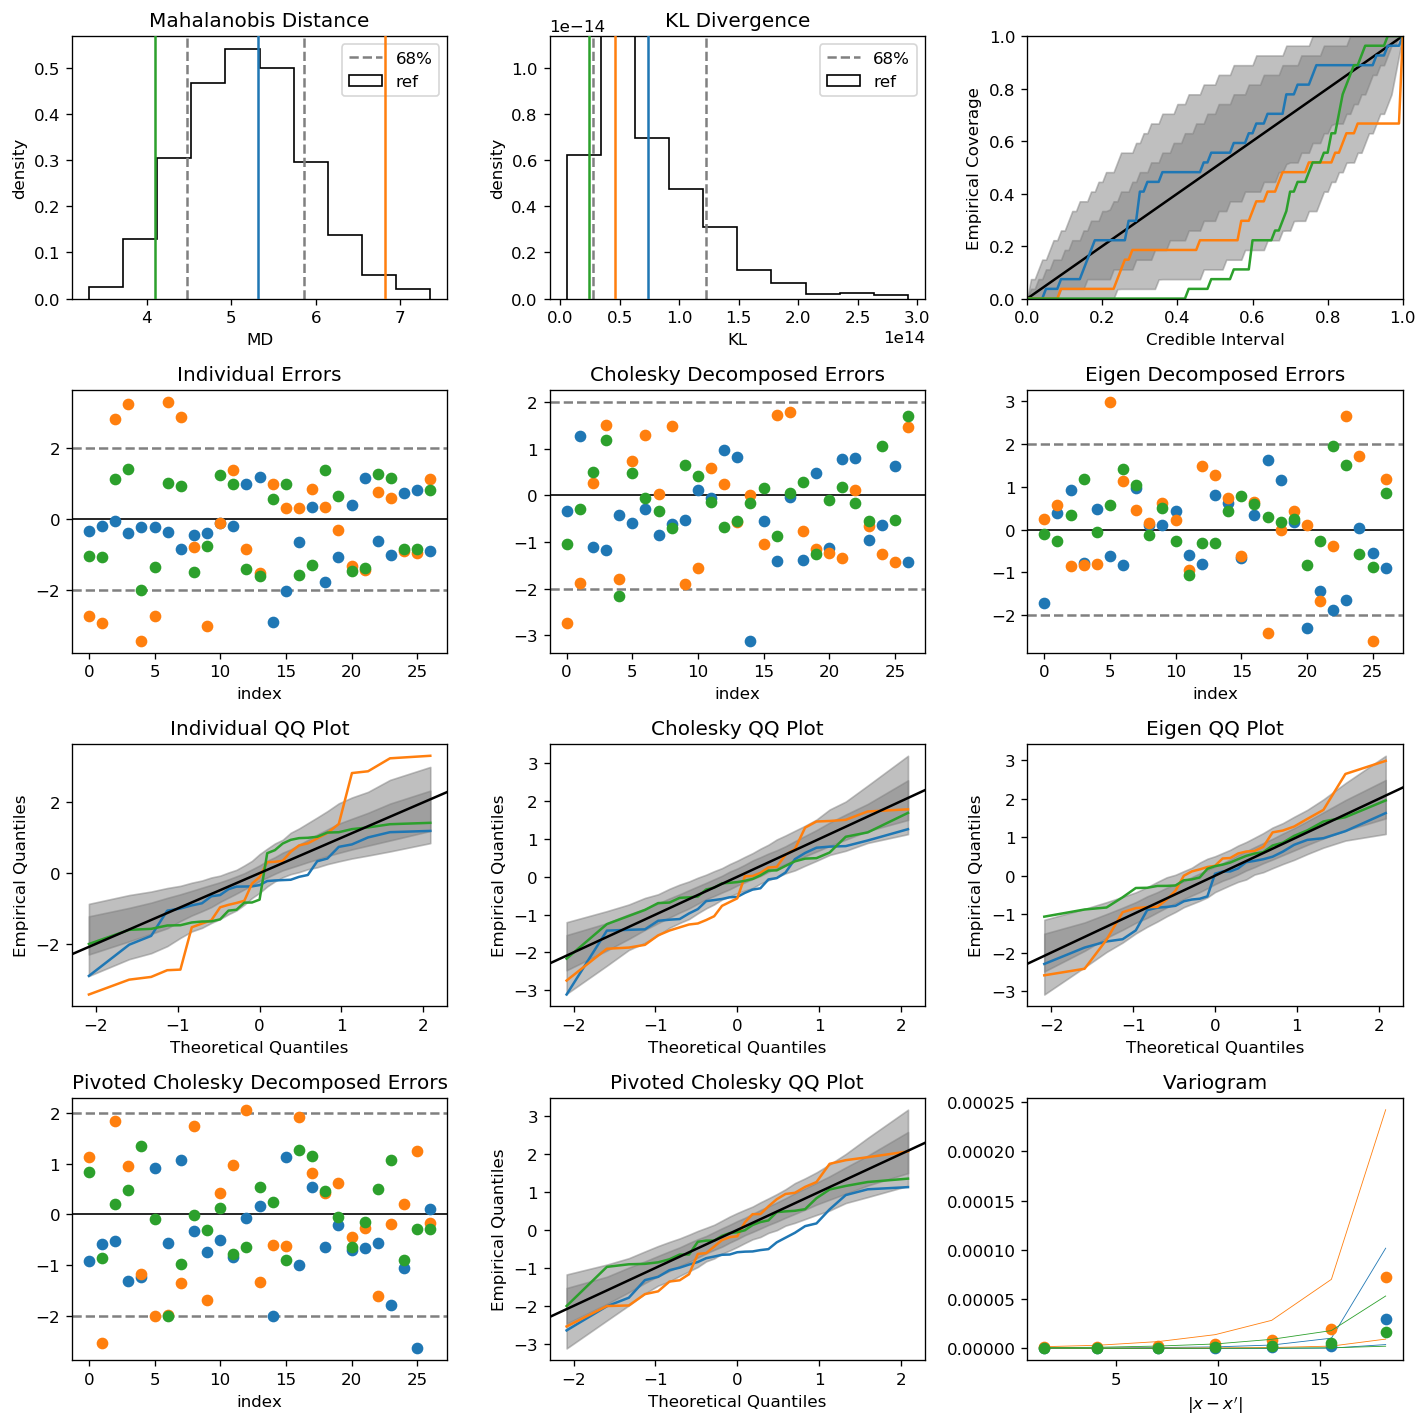

In [32]:
mean_test, cov_test = gp.predict(X_test, return_cov=True, pred_noise=True)

gpmc = Diagnostic(np.zeros(mean_test.shape[1]), cov_test)
gd = GraphicalDiagnostic(gpmc, toy_data_test-mean_test, nref=n_ref)
gd.plotzilla(X_test, gp_static, vlines=vlines);

These look a bit more "as expected" than with the two seeds considered above, in that orange is failing perhaps a bit too often (see esp. upper half of eigen error QQ plot) and green succeeding (suc-seed-ing?) a bit too often (see PC QQ or Eigen QQ plot). 